# Исследование пользователей сервиса аренды самокатов
Вам передали данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. В основных данных есть информация о пользователях, их поездках и подписках.  

Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти:
1. Найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.  
2. Найдем помесячную выручку, которую принёс каждый пользователь.  
3. Определим сколько времени тратят пользователи с подпиской и без подписки.  
4. Опредилим можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.  
5. Проверим будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import sqrt

## Загрузка данных

In [2]:
# Прочитаем данные из csv-файлов в датафрейм и сохраним их в переменные user, ride и subscription.
user = pd.read_csv(r'users_go.csv')
ride = pd.read_csv(r'rides_go.csv')
subscription = pd.read_csv(r'subscriptions_go.csv')

In [3]:
# Выведем первые строки датафреймов и основную информацию по ним на экран.
display(user.head())
user.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице 5 столбцов по 1565 сток, количество значений в столбцах не различается, значит пропусков нет.

In [4]:
display(ride.head())
ride.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице 4 столбца по 18068 сток, количество значений в столбцах не различается, значит пропусков нет. В столбце date нужно поменять тип данных.

In [5]:
display(subscription.head())
subscription.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В таблице 4 столбца по 2 стоки, пропусков нет.

## Предобработка данных

In [6]:
# Выведем на экран количество строк дубликатов в данных по таблице user и ride
user.duplicated().sum()

31

In [7]:
# удалим дубликаты
user = user.drop_duplicates()

In [8]:
# Проверим все ли удалось убрать
ride.duplicated().sum()

0

In [9]:
# Преобразуем тип данных в столбеце date.
ride['date'] = pd.to_datetime(ride['date'], format='%Y-%m-%d')

In [10]:
# Создадим новый столбец с номером месяца на основе столбца date.
ride['month'] = ride['date'].dt.month

На данном этапе мы избавились от дубликатов, поправили формат даты и добавили столбец с номером месяца для сортировки по месяцам в дальнейшем.

## Исследовательский анализ данных

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

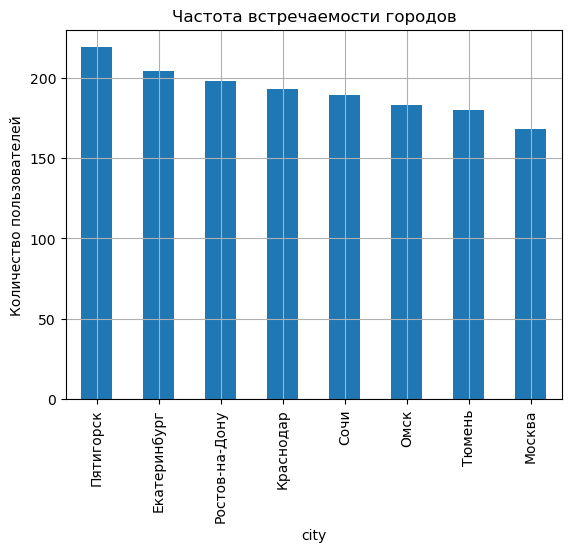

In [11]:
# Рассмотрим частоту встречаемости городов
city_gr = user['city'].value_counts()
display(city_gr)
ax = city_gr.plot.bar(grid=True)
plt.title('Частота встречаемости городов')
plt.ylabel('Количество пользователей')
plt.show()

Наибольшей популярностью сервис аренды самокатов пользуется в Пятигорске, Екатеринбурге и Ростове-на-Дону.

subscription_type
free     835
ultra    699
Name: count, dtype: int64

Конверсия тарифа с подпиской: 46%
Конверсия тарифа без подписки: 54%


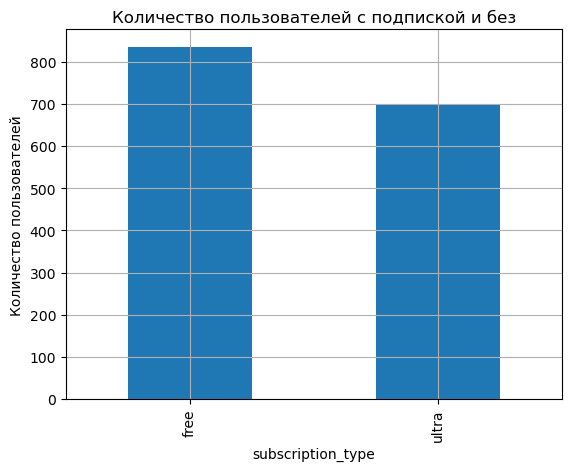

In [12]:
# Определим соотношение пользователей с подпиской и без подписки. 
subscription_type_gr = user['subscription_type'].value_counts()
display(subscription_type_gr)
ultra = 699/(699+835)
free = 835/(699+835)
print(f'Конверсия тарифа с подпиской: {ultra:.0%}')
print(f'Конверсия тарифа без подписки: {free:.0%}')
ax = subscription_type_gr.plot.bar(grid=True)
plt.title('Количество пользователей с подпиской и без')
plt.ylabel('Количество пользователей')
plt.show()

Чаще пользуются сервисом пользователи без подписки, несмотря на это у компании есть неплохая база постоянных клиентов.

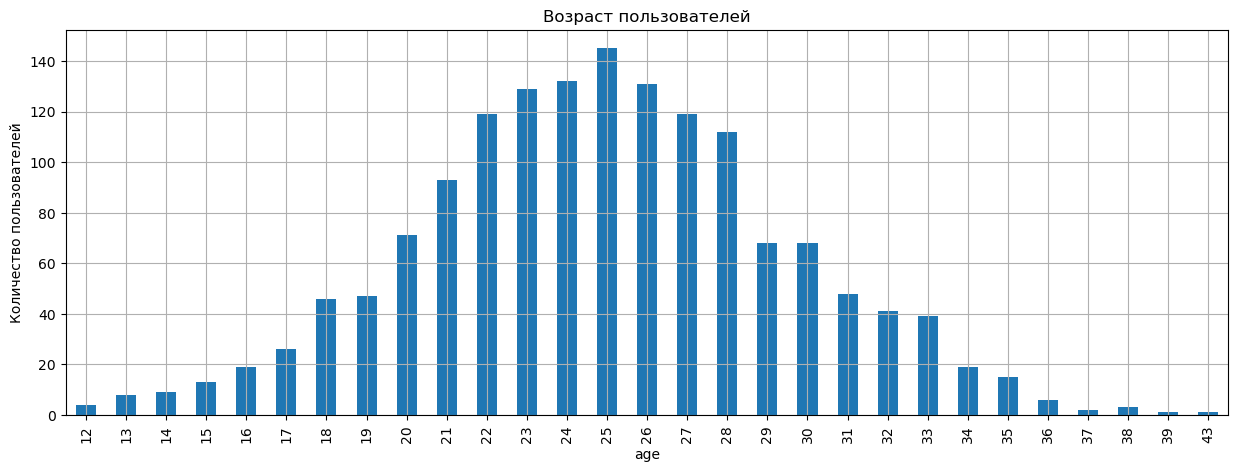

In [13]:
# Найдем возраст пользователей.
age_gr = user.groupby('age')['user_id'].count()
ax = age_gr.plot.bar(grid=True, figsize=(15,5))
plt.title('Возраст пользователей')
plt.ylabel('Количество пользователей')
plt.show()

Основная часть пользователей возрастом от 22 до 28 лет. Медиана: 25 лет. Все что меньше 15 лет и больше 40 можно считать редкими значениями.

In [14]:
user.drop(index=user.query('age < 16').index,inplace=True)
user.drop(index=user.query('age > 35').index,inplace=True)
age_gr = user.groupby('age')['user_id'].count()
display(age_gr)

age
16     19
17     26
18     46
19     47
20     71
21     93
22    119
23    129
24    132
25    145
26    131
27    119
28    112
29     68
30     68
31     48
32     41
33     39
34     19
35     15
Name: user_id, dtype: int64

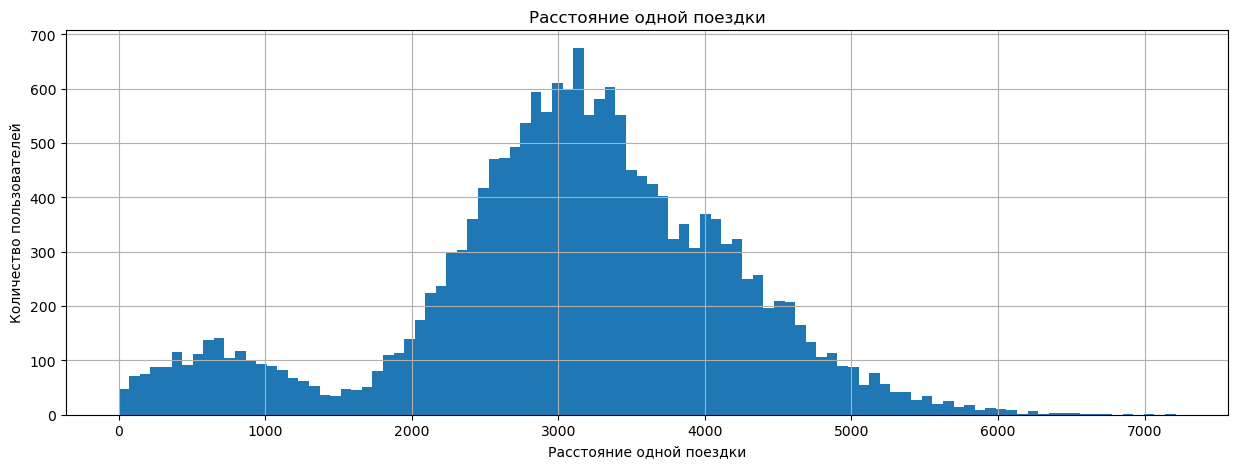

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64


In [15]:
# Представим на гистограмме и на диаграмме размаха расстояние, которое преодолевают пользователи за одну поездку.
ride['distance'].hist(bins=100, figsize=(15,5))
plt.title('Расстояние одной поездки')
plt.ylabel('Количество пользователей')
plt.xlabel('Расстояние одной поездки')
plt.show()
print(ride['distance'].describe())

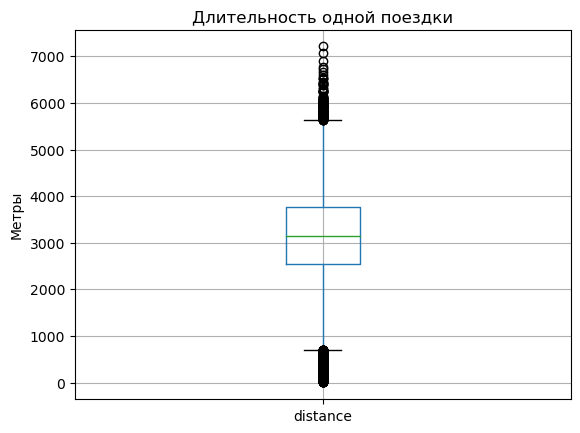

In [16]:
ride.boxplot('distance')
plt.title('Длительность одной поездки')
plt.ylabel('Метры');

Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.

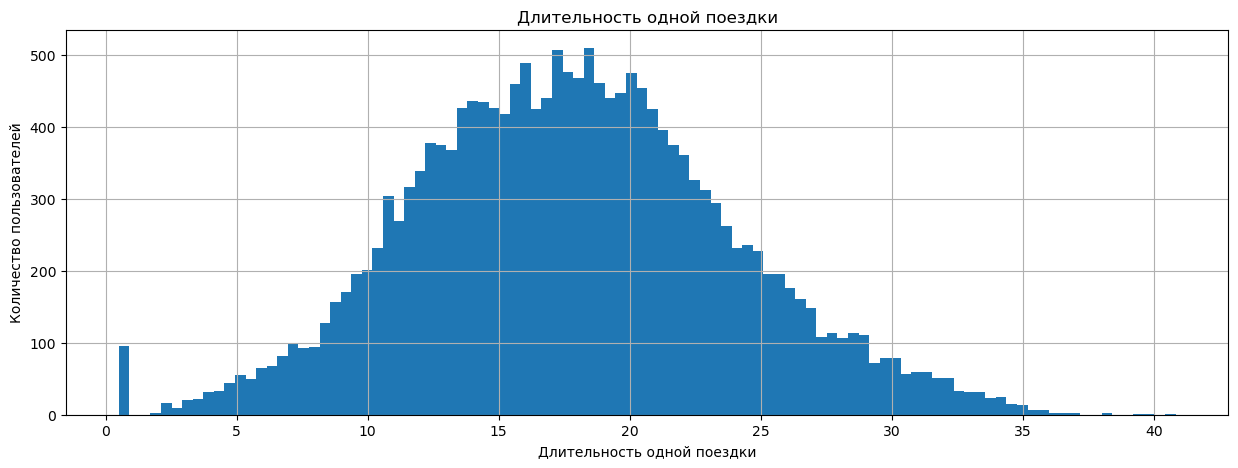

In [17]:
# Представим на гистограмме и на диаграмме размаха продолжительность одной поездки.
ride['duration'].hist(bins=100, figsize=(15,5))
plt.title('Длительность одной поездки')
plt.ylabel('Количество пользователей')
plt.xlabel('Длительность одной поездки')
plt.show()

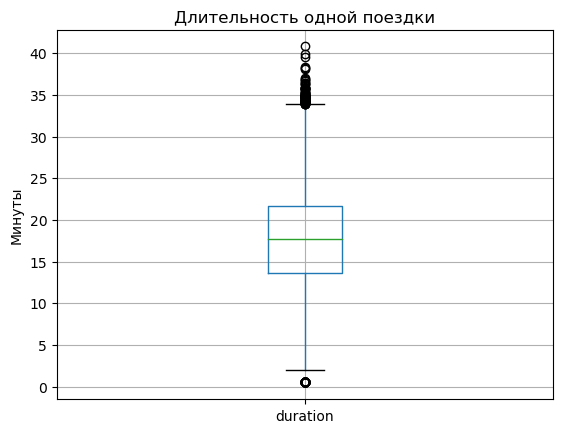

In [18]:
ride.boxplot('duration')
plt.title('Длительность одной поездки')
plt.ylabel('Минуты');

Продолжительность поездок чаще составляет 14-22 мин. Медиана длительности поездок 18 мин. Присутствует выборс  по времени 0,5 мин и свыше 35 минут, уберем эти данные.

In [19]:
ride.drop(index=ride.query('duration < 1').index,inplace=True)
ride.drop(index=ride.query('duration > 35').index,inplace=True)
ride['duration'].describe()

count    17945.000000
mean        17.867270
std          5.933817
min          2.035632
25%         13.661701
50%         17.707151
75%         21.725567
max         34.962659
Name: duration, dtype: float64

## Объединение данных

In [20]:
print(user.shape)#посмотрим размерность таблицы Пользователей
print(ride.shape)#посмотрим размерность таблицы Поездок

(1487, 5)
(17945, 5)


In [21]:
# Объединим данные о пользователях, поездках и подписках в один датафрейм.
df = user.merge(ride, on='user_id')
display(df.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [22]:
print(df.shape)#посмотрим размерность объединенной таблицы
print(df.isna().sum())#и не образовались ли пропуски

(17373, 9)
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64


In [23]:
# Создадим датафрейм с данными о пользователях с подпиской.
df_ultra = df.query('subscription_type == "ultra"')
display(df_ultra.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [24]:
# Создадим датафрейм с данными о пользователях без подписки.
df_free = df.query('subscription_type == "free"')
display(df_free.head())

,user_id,name,age,city,subscription_type,distance,duration,date,month
6246,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6247,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6248,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6249,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6250,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2


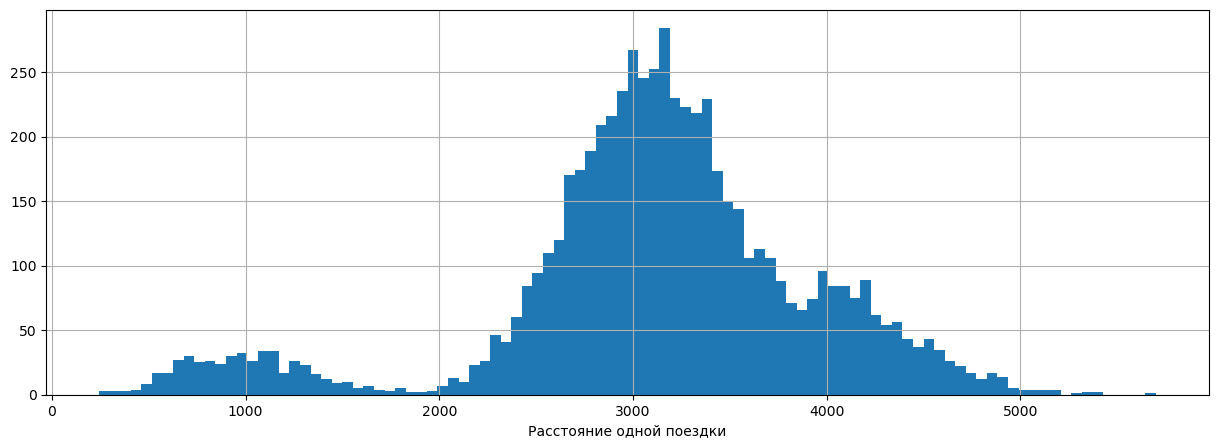

count    6246.000000
mean     3110.675084
std       831.944148
min       244.210438
25%      2783.615366
50%      3145.682080
75%      3554.451697
max      5699.769662
Name: distance, dtype: float64


In [25]:
# Построим гистограммы с информацие о расстоянии поездок для пользователей на  тарифе с подпиской
df_ultra['distance'].hist(bins=100, figsize=(15,5))
plt.xlabel('Расстояние одной поездки')
plt.show()
print(df_ultra['distance'].describe())

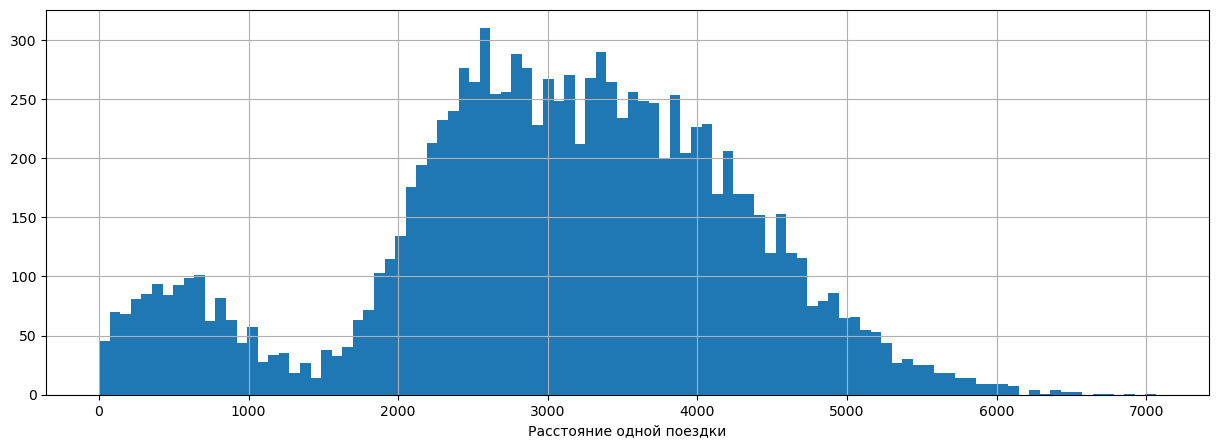

count    11127.000000
mean      3028.068479
std       1237.472560
min          0.855683
25%       2359.713130
50%       3101.110992
75%       3886.428646
max       7066.003772
Name: distance, dtype: float64


In [26]:
# Построим гистограммы с информацие о расстоянии поездок для пользователей на  тарифе без подписки
df_free['distance'].hist(bins=100, figsize=(15,5))
plt.xlabel('Расстояние одной поездки')
plt.show()
print(df_free['distance'].describe())

У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей. Пользователи с подпиской чаще совершают поездки на расстояние 2,8 - 3,5 км. Расстояние поездки  для пользовалетели без подписки 2,4 - 3,9 км.

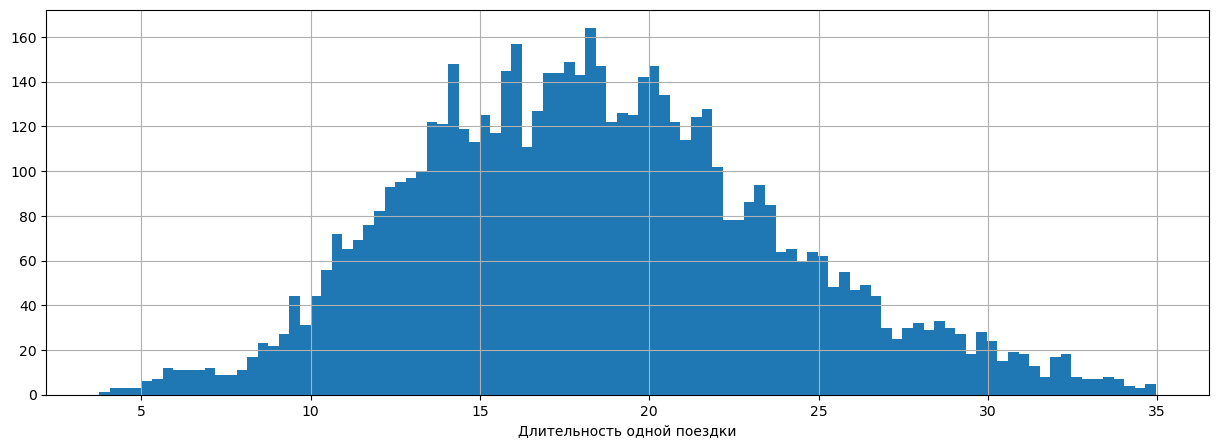

count    6246.000000
mean       18.455814
std         5.448735
min         3.760353
25%        14.493456
50%        18.154184
75%        21.809100
max        34.962659
Name: duration, dtype: float64

In [27]:
# Построим гистограммы с информацие о времени поездок для пользователей на  тарифе с подпиской
df_ultra['duration'].hist(bins=100, figsize=(15,5))
plt.xlabel('Длительность одной поездки')
plt.show()
df_ultra['duration'].describe()

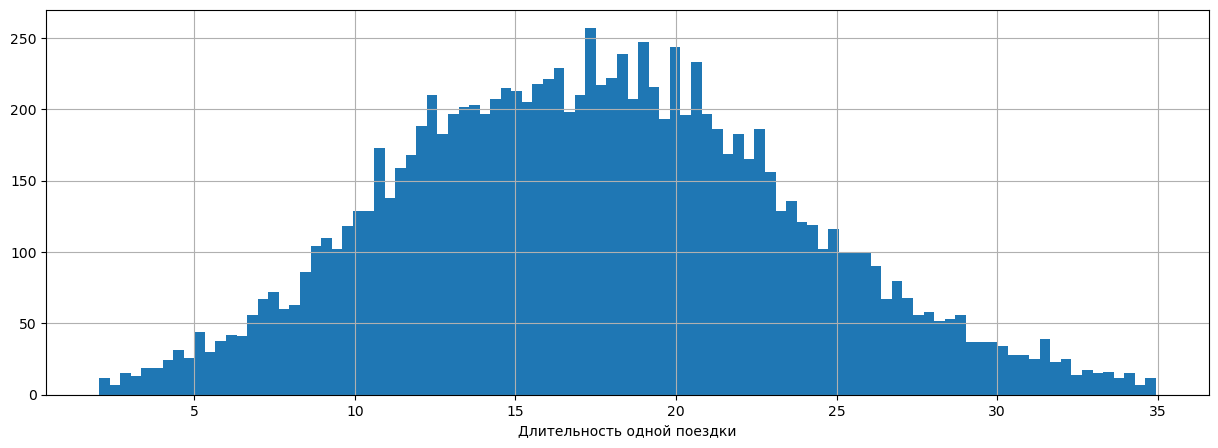

count    11127.000000
mean        17.527207
std          6.159695
min          2.035632
25%         13.082230
50%         17.392830
75%         21.641394
max         34.948498
Name: duration, dtype: float64

In [28]:
# Построим гистограммы с информацие о времени поездок для пользователей на  тарифе без подписки
df_free['duration'].hist(bins=100, figsize=(15,5))
plt.xlabel('Длительность одной поездки')
plt.show()
df_free['duration'].describe()

В целом картина такая же - распределение внутри категорий имеют одинаковый профиль (и одинаковый с профилем распределения до разбивки на категории - строили на ранних этапах), но в каждом из диапазонов бесплатных пользователей чуть больше, но их, как мы помним, и в целом больше.
Краевые значения (минимум и максимум) у бесплатных пользователей смещены влево относительно платных подписчиков - стоимость минуты все-таки больше, значит часть пользователей торопится завершить поездки за меньший срок. Но при этом визуально среднее значение не сильно смещено. Длительность одной поездки для пользователей с подпиской чаще составляет 15 - 22 мин., без подписки 13 - 22 мин.

## Подсчёт выручки

In [29]:
# Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными: 
# найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
df_grouped = df.groupby(['user_id', 'month', 'subscription_type']).agg({'distance':['sum', 'count'], \
                                                                                'duration': ['sum']})
df_grouped.columns = ['distance_sum', 'count', 'duration_sum']
# каждое значение из столбца duration округляется с помощью «потолка»: 
df_grouped['duration_sum'] = np.ceil(df_grouped['duration_sum'])
df_grouped.reset_index(['subscription_type', 'month', 'user_id'], inplace = True)
display(df_grouped.head(10))

,user_id,month,subscription_type,distance_sum,count,duration_sum
0,1,1,ultra,7027.511294,2,42.0
1,1,4,ultra,754.159807,1,7.0
2,1,8,ultra,6723.470560,2,45.0
3,1,10,ultra,5809.911100,2,32.0
4,1,11,ultra,7003.499363,3,54.0
5,1,12,ultra,6751.629942,2,28.0
6,2,3,ultra,10187.723006,3,61.0
7,2,4,ultra,6164.381824,2,40.0
8,2,6,ultra,3255.338202,1,14.0
9,2,7,ultra,6780.722964,2,47.0


In [30]:
print(df_grouped.isna().sum())#проверим таблицу на наличие пропусков

user_id              0
month                0
subscription_type    0
distance_sum         0
count                0
duration_sum         0
dtype: int64


In [31]:
# Добавим столбец с помесячной выручкой, которую принёс каждый пользователь.
df_grouped = df_grouped.merge(subscription, on='subscription_type')
df_grouped['revenue_month'] = df_grouped['start_ride_price'] * df_grouped['count'] + df_grouped['minute_price'] * df_grouped['duration_sum'] + df_grouped['subscription_fee']
display(df_grouped.head())
display(df_grouped.tail())

,user_id,month,subscription_type,distance_sum,count,duration_sum,minute_price,start_ride_price,subscription_fee,revenue_month
0,1,1,ultra,7027.511294,2,42.0,6,0,199,451.0
1,1,4,ultra,754.159807,1,7.0,6,0,199,241.0
2,1,8,ultra,6723.470560,2,45.0,6,0,199,469.0
3,1,10,ultra,5809.911100,2,32.0,6,0,199,391.0
4,1,11,ultra,7003.499363,3,54.0,6,0,199,523.0


,user_id,month,subscription_type,distance_sum,count,duration_sum,minute_price,start_ride_price,subscription_fee,revenue_month
10923,1534,6,free,3409.468534,2,25.0,8,50,0,300.0
10924,1534,8,free,7622.453034,2,48.0,8,50,0,484.0
10925,1534,9,free,4928.173852,1,23.0,8,50,0,234.0
10926,1534,11,free,13350.015305,4,77.0,8,50,0,816.0
10927,1534,12,free,2371.711192,1,16.0,8,50,0,178.0


## Проверка гипотез

***1. Проверим тратят ли пользователи с подпиской больше времени на поездки.***  
Для этого используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.  
Нулевая гипотеза: Две эти группы демонстрируют одинаковую длительность.   
Альтернативная гипотеза: Две эти группы демонстрируют разную длительность.   

In [32]:
alpha = 0.05
results = st.ttest_ind(df_ultra['duration'], 
                       df_free['duration'], 
                       equal_var=False, 
                       alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Гипотеза верна')

p-значение: 5.403015208299657e-25
Отвергаем гипотезу


Гипотеза не подтвердилась, поэтому пользователи с подпиской и без подписки представляют для компании одинаковый интерес.

***2. Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.***   
Нулевая гипотеза:расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.   
Альтернативна гипотеза: расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров. 

In [33]:
optimal_distance = 3130
alpha = 0.05
results = st.ttest_1samp(df_ultra['distance'], 
                         optimal_distance, 
                         alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Гипотеза верна')

p-значение: 0.9667823263121742
Гипотеза верна


Гипотеза подтвердилась: расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

***3. Сравним выручку от пользователей с подпиской и без.***  
Нулевая гипотеза: пользователи тарифа ulrta демонтрируют большую выручку, чем пользователи тарифа free.  
Альтернативная гипотеза: пользователи тарифа free демонтрируют большую выручку, чем пользователи тарифа ulrta

In [34]:
revenue_ultra = df_grouped[df_grouped['subscription_type'] == 'ultra']['revenue_month']
revenue_free = df_grouped[df_grouped['subscription_type'] == 'free']['revenue_month']
results = st.ttest_ind(revenue_ultra, revenue_free, equal_var=False, alternative='greater')
alpha = 0.05
print(results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Гипотеза верна')

4.5382739872641744e-40
Отвергаем нулевую гипотезу


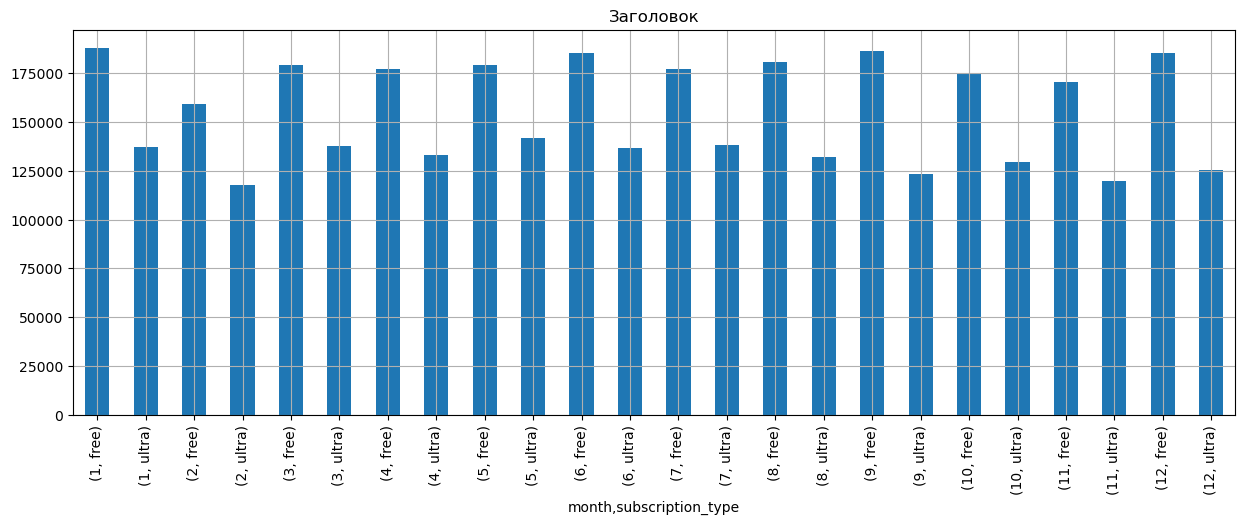

In [35]:
df_grouped_month = df_grouped.groupby(['month', 'subscription_type'])['revenue_month'].sum()
df_grouped_month.plot(kind="bar", grid=True, figsize=(15,5), title = 'Заголовок');

Как видно из графика выручка от пользователей с подпиской каждый месяц была ниже, чем у пользователей без подписки.

###### Предположим, что техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение.  
Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Для решения потребуется тест на равенство средних для зависимых выборок, до и после изменений (методом scipy.stats.ttest_rel()).

**Выводы:**  
Наибольшей популярностью сервис аренды самокатов пользуется в Пятигорске, Екатеринбурге и Ростове-на-Дону. Чаще пользуются сервисом пользователи возростной группы 22-28 лет.  

Конверсия тарифа с подпиской: 46%. Конверсия тарифа без подписки: 54%  

Расстояние которое пользователи чаще преодолевают за одну поездку 2,5 - 3,7 км, некоторая часть пользователей использует самокаты для коротких поездок - до 1,5 км. Причем пользователи с подпиской совершают поездки на расстояние 2,8 - 3,5 км. Расстояние поездки для пользовалетели без подписки 2,4 - 3,9 км.У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.  

Продолжительность поездок чаще составляет 14-22 мин. Длительность одной поездки для пользователей с подпиской составляет 15 - 22 мин., без подписки 13 - 22 мин.  

Все это говорит о большей популярности тарифа без подписки, не смотря на то что пользователей с подпиской также достаточно много.

Наши предположения о том, что длительность поездок, а также выручка от пользователей с подпиской больше не подтвердились. Подтвердилась гипотеза, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.     

Для привлечения новых постоянных клиентов возможно стоило бы пересмотреть тарифную сетку на тарифе с подпиской, либо предусмотреть пробные акции для привлечение клиентов.
